# **Kết nối Google Drive**

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from os import path

# root_path = '/content/gdrive/MyDrive/TÀI LIỆU HỌC ĐẠI HỌC/Năm 3 (2023-2024)/Nhập Môn Bảo Đảm Và An Ninh Thông Tin/ANNINH_ANGIANG'
root_path = '/content/gdrive/MyDrive/TÀI LIỆU HỌC ĐẠI HỌC/Năm 3 (2023-2024)/Nhập Môn Bảo Đảm Và An Ninh Thông Tin/ANNINH_ANGIANG'
# root_path = '/content/gdrive/MyDrive/TÀI LIỆU HỌC ĐẠI HỌC/Năm 3 (2023-2024)/Nhập Môn Bảo Đảm Và An Ninh Thông Tin/ANNINH_ANGIANG'

dataset_path = path.join(root_path, 'IMG_DATASET')
benign_path = path.join(dataset_path, 'benign')
malware_path = path.join(dataset_path, 'malware')
!ls "$root_path"

Code		  DikeDatasetIMG	  IMG_DATASET	     Paper
Code_IE105.ipynb  DikeDatasetIMG.zip	  IMG_DATASET.zip    Project
Datasets	  Flower_framework.ipynb  Install_lib.ipynb  XuLyAnh.ipynb


# **Cài đặt các Phụ thuộc (Dependencies)**

In [3]:
!pip install flwr["simulation"]
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 14.8 MB/s eta 0:00:00


In [4]:
# @title Set seed
import torch
import tensorflow as tf

import random, os
import numpy as np

def set_global_seeds(seed):

    # Overall
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Tf
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def set_seed(seed):
    set_global_seeds(seed)

    # Tf
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.experimental.enable_op_determinism()

    # Torch
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

    print("SET SEED:", seed)

In [5]:
CLASSES = (
    "benign",
    "malware"
)

NUM_CLIENTS = 10
BATCH_SIZE = 1024

RANDOM_SEED = 42

HEIGHT = 224
WIDTH = 224

EPOCHS = 4
ROUND_SIMULATION = 5
VAL_SIZE = 0.1

set_seed(RANDOM_SEED)

SET SEED: 42


Source: https://colab.research.google.com/github/adap/flower/blob/main/doc/source/tutorial-series-get-started-with-flower-pytorch.ipynb#scrollTo=jlXJatl0Yp3a

# **Khai báo các thư viện**

In [6]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Định nghĩa DataLoader**

In [7]:
def load_datasets(dataset_path, validation_size = 10):
    transform = transforms.Compose([
        transforms.Resize((HEIGHT, WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = ImageFolder(root=path.join(dataset_path, 'train'), transform=transform)
    testset = ImageFolder(root=path.join(dataset_path, 'test'), transform=transform)

    # Split training set into num_clients partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS

    if len(trainset) != NUM_CLIENTS * partition_size:
        # Adjust trainset to fit partition_size * NUM_CLIENTS
        trainset_partitions = [Subset(trainset, range(i * partition_size, (i + 1) * partition_size)) for i in range(NUM_CLIENTS)]
        trainset = torch.utils.data.ConcatDataset(trainset_partitions)

    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(RANDOM_SEED))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = int(len(ds) * validation_size)  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(RANDOM_SEED))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(dataset_path = dataset_path, validation_size = VAL_SIZE)

# **Hiển thị đặc trưng (Feature) ở dạng hình ảnh**

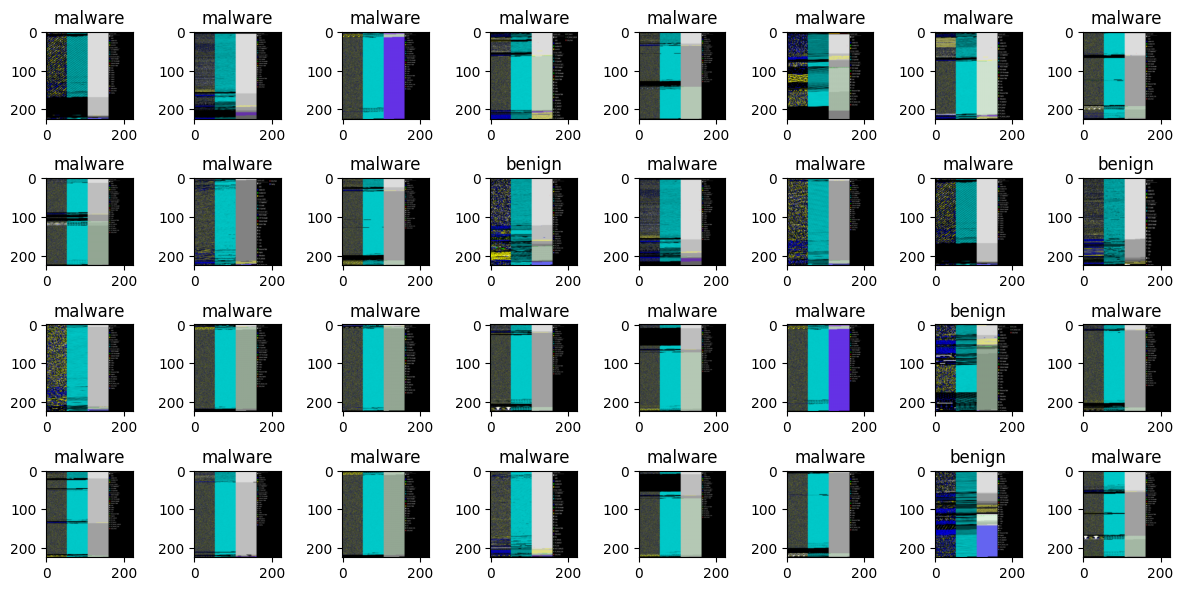

In [8]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    # ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

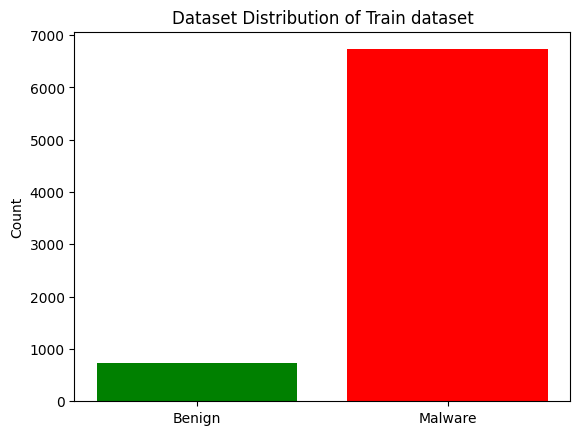

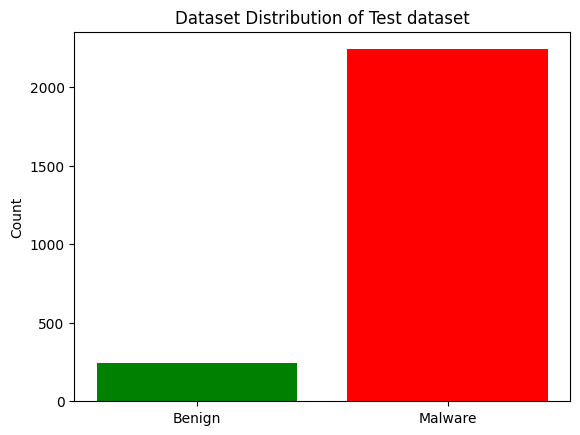

In [9]:
import os

def plot_dataset_distribution(data_type):
    dict_count = {}
    for class_name in os.listdir(path.join(dataset_path, data_type)):
        dict_count[class_name.capitalize()] = len(os.listdir(path.join(dataset_path, data_type, class_name)))

    labels, counts = zip(*dict_count.items())

    plt.bar(labels, counts, color=['green', 'red'])
    plt.title('Dataset Distribution of ' + data_type.capitalize() + ' dataset')
    plt.xlabel('')
    plt.ylabel('Count')

    plt.show()

plot_dataset_distribution(data_type = 'train')
plot_dataset_distribution(data_type = 'test')

# **Định nghĩa Neural Network Model**

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.dropout = nn.Dropout(0.1)

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(CLASSES))

    def forward(self, x):

        x = self.dropout(x)
        x = self.pool(F.relu(self.conv1(x)))

        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 53 * 53)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# **Train và Test bộ dữ liệu**

In [11]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


def calculate_class_weights(trainloader):
    num_classes = len(CLASSES)
    class_counts = torch.zeros(num_classes)

    for _, labels in trainloader:
        class_counts += torch.bincount(labels, minlength=num_classes)

    total_samples = sum(class_counts)
    class_weights = total_samples / (num_classes * class_counts)

    return class_weights.to(DEVICE)

def train(net, trainloader, epochs: int, verbose=False):

    """Train the network on the training set."""
    class_weights = calculate_class_weights(trainloader)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    if verbose:
        print("Weighted :", class_weights)

    # criterion = nn.CrossEntropyLoss()


    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        preds, trues = [], []
        epoch_loss = 0.0
        with tqdm(total=len(trainloader)) as pbar:
            for images, labels in trainloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Metrics
                epoch_loss += loss

                predicted = np.argmax(outputs.data.cpu(), axis = 1)
                preds.extend(predicted)
                trues.extend(labels.cpu())

                pbar.update(1)

        epoch_loss /= len(trainloader.dataset)

        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}")
            print(classification_report(trues, preds, zero_division= 0.0))
            print()

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    preds, trues = [], []

    criterion = torch.nn.CrossEntropyLoss()
    loss = 0.0
    net.eval()
    with torch.no_grad():
        with tqdm(total=len(testloader)) as pbar:
            for images, labels in testloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = net(images)
                loss += criterion(outputs, labels).item()

                predicted = np.argmax(outputs.data.cpu(), axis = 1)
                preds.extend(predicted)
                trues.extend(labels.cpu())

                pbar.update(1)

    accuracy = accuracy_score(trues, preds)
    precision = precision_score(trues, preds, average='weighted')
    recall = recall_score(trues, preds, average='weighted')
    f1 = f1_score(trues, preds, average='weighted')

    print(classification_report(trues, preds, zero_division = 0.0))
    print()

    binary = confusion_matrix(trues, preds)

    fig, ax = plot_confusion_matrix(conf_mat=binary,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    class_names=CLASSES)
    plt.show()

    return loss, accuracy, precision, recall, f1, binary

# **Đào tạo và đánh giá, kiểm thử mô hình**

Net(
  (dropout): Dropout(p=0.1, inplace=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

Weighted : tensor([5.7931, 0.5472], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: train loss 0.0010372267570346594
              precision    recall  f1-score   support

           0       0.09      1.00      0.16        58
           1       1.00      0.00      0.00       614

    accuracy                           0.09       672
   macro avg       0.54      0.50      0.08       672
weighted avg       0.92      0.09      0.02       672




  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2: train loss 0.0009065605700016022
              precision    recall  f1-score   support

           0       0.80      0.28      0.41        58
           1       0.94      0.99      0.96       614

    accuracy                           0.93       672
   macro avg       0.87      0.63      0.69       672
weighted avg       0.92      0.93      0.92       672




  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3: train loss 0.004203268326818943
              precision    recall  f1-score   support

           0       0.09      1.00      0.16        58
           1       0.00      0.00      0.00       614

    accuracy                           0.09       672
   macro avg       0.04      0.50      0.08       672
weighted avg       0.01      0.09      0.01       672




  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4: train loss 0.0010178940137848258
              precision    recall  f1-score   support

           0       0.09      1.00      0.16        58
           1       0.00      0.00      0.00       614

    accuracy                           0.09       672
   macro avg       0.04      0.50      0.08       672
weighted avg       0.01      0.09      0.01       672




  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.90      1.00      0.95      2242

    accuracy                           0.90      2488
   macro avg       0.45      0.50      0.47      2488
weighted avg       0.81      0.90      0.85      2488




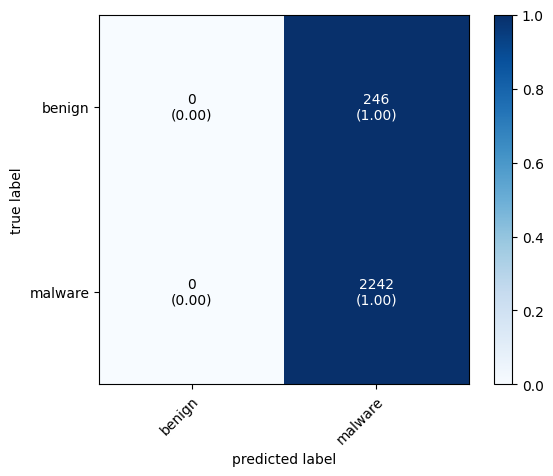

Final test set performance:
	loss 0.906941831111908
	accuracy 0.9011254019292605


In [12]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)
print(net)
print()

train(net, trainloader, EPOCHS, verbose = True)

loss, accuracy, precision, recall, f1, cm = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

# **Thiết lập trọng số**

In [13]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# **Triển khai một Flower client**

In [14]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy, precision, recall, f1, cm  = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy), "precision": float(precision), "recall": float(recall), "f1": float(f1), "cm": cm}

# **Sử dụng  Virtual Client Engine**

In [15]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

# **Thiết lập Accuracy**

In [16]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    precisions = [num_examples * m["precision"] for num_examples, m in metrics]
    recalls = [num_examples * m["recall"] for num_examples, m in metrics]
    f1s = [num_examples * m["f1"] for num_examples, m in metrics]
    cms = [num_examples * m["cm"] for num_examples, m in metrics]

    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples), "precision": sum(precisions) / sum(examples), "recall": sum(recalls) / sum(examples), "f1": sum(f1s) / sum(examples), "cm": sum(cms) / sum(examples)}

# **Bắt đầu đào tạo**

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=int(NUM_CLIENTS * 0.2),
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUND_SIMULATION),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-12-09 03:37:27,752 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-12-09 03:37:32,436	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-09 03:37:35,078 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7888760832.0, 'CPU': 2.0, 'object_store_memory': 3944380416.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7888760832.0, 'CPU': 2.0, 'object_store_memory': 3944380416.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-12-09 03:37:35,081 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


In [ ]:
history